In [ ]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value, ±
using Graphs
using JLD2

In [ ]:
N = 10^3
seed = 1
rng = MersenneTwister(seed)
gg = prufer_decode(rand(rng, 1:N, N-2))
g = IndexedGraph(gg)
T = 50     # final time
Δt = 1.0   # discretization
λ = 0.3    # prob. of transmission
ρ = 0.2   # prob. of recovery

j = argmax(degree(g,j) for j in vertices(g))
γ = [i==j ? 1.0 : 0.0 for i in 1:N]
# γ = fill(3/N, N)

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*Δt, ρ*Δt, floor(Int, T/Δt); γ)

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [ ]:
j

In [ ]:
matrix_sizes = [2, 3, 5, 8, 12]
maxiters = fill(50, length(matrix_sizes))
iters = zeros(Int, length(maxiters))
tol = 1e-4
p_bp = Vector{Vector{Float64}}(undef, length(matrix_sizes))
cb = CB_BP(bp)
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), tol, cb)
    p_bp[i] = means((x,i)->x-1, bp)[j]
end

In [ ]:
replace!(cb.Δs, 0 => tol)
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [ ]:
using ColorSchemes

cg = cgrad(:matter, length(matrix_sizes), categorical=true)
pl = plot()
for i in eachindex(matrix_sizes)
    plot!(pl, 0:T, p_bp[i], xlabel="time", ylabel=L"p(x_{%$j}^t=I)", label=L"M={%$(matrix_sizes[i])}",
        size=(500,300), xticks=0:2:T, ms=3, legend=:bottomright, msc=:auto, c=cg[i])
end
plot(pl, size=(900,400), margin=5Plots.mm)

## Monte Carlo

In [ ]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [ ]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
rng = MersenneTwister(1)
nsamples_mc = 10^5
sample!(sms, nsamples_mc; rng);

In [ ]:
b_mc = marginals(sms)
p_mc = [[value(bb[INFECTED]/sum(bb)) for bb in b] for b in b_mc];

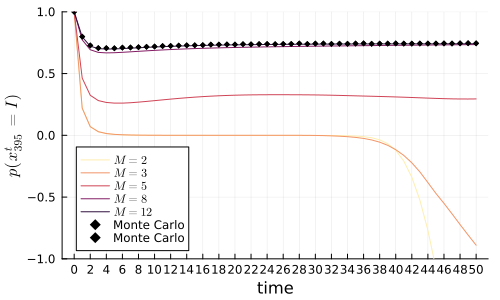

In [15]:
plot!(pl, 0:T, p_mc[j], c=:black, m=:diamond, ms=3, msc=:auto, label="Monte Carlo", st=:scatter,
    legend = :bottomleft, ylims=(-1,1))

In [ ]:
# jldsave("plot_data/sis_tree_bonddims.jld2"; T, N, j, λ, ρ, γ, p_bp, p_mc, matrix_sizes);